In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords  #pip install nltk
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
from nltk.stem.porter import PorterStemmer
import string
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from gensim.models import word2vec  #pip install word2vec
from wordcloud import WordCloud  #pip install wordcloud
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import NMF, LatentDirichletAllocation
from textblob import TextBlob  #Sentiment Analysis - pip install textblob
from sklearn.decomposition import TruncatedSVD, NMF
import matplotlib.patches as mpatches
import matplotlib
path_to_csv = '../../../../cs82_advanced_machine_learning_data/HW2/papers.csv'

[nltk_data] Error loading stopwords: <urlopen error [WinError 10053]
[nltk_data]     An established connection was aborted by the software
[nltk_data]     in your host machine>


C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 1. Plotting wordcloud to get an idea of important words

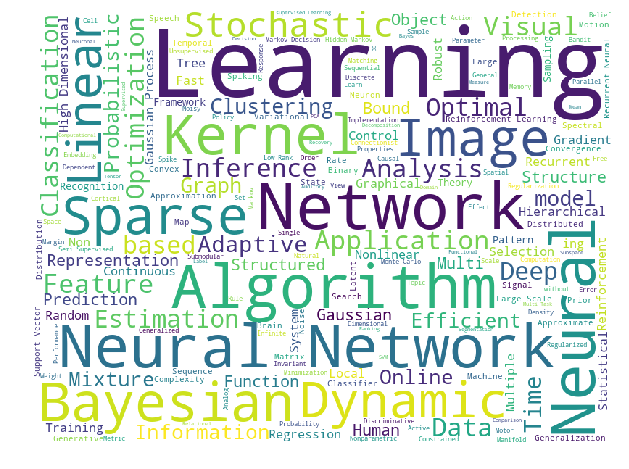

In [2]:
papers = pd.read_csv(path_to_csv)
features=['title']
papers=papers.loc[:,features]

#removing undesired words from the data 
papers['title'] = papers['title'].str.replace('Abstract Missing','')
papers['title'] = papers['title'].str.replace('Using','')
papers['title'] = papers['title'].str.replace('using','')
papers['title'] = papers['title'].str.replace("New",'')
papers['title'] = papers['title'].str.replace("Based",'')
papers['title'] = papers['title'].str.replace('Use','')
papers['title'] = papers['title'].str.replace('Used','')
papers['title'] = papers['title'].str.replace('Method','')
papers['title'] = papers['title'].str.replace('Problem','')
papers['title'] = papers['title'].str.replace('Approach','')
papers['title'] = papers['title'].str.replace('Model','')
papers['title'] = papers['title'].str.replace('Models','')
papers['title'] = papers['title'].str.replace('via','')

papers=papers.sample(frac=1,random_state=0)
train_qs = pd.Series(papers['title'].tolist()).astype(str)

qs_text = "".join(train_qs)

cloud =WordCloud(font_path=None, width=800, height=600, margin=2, ranks_only=None, 
                 prefer_horizontal=0.9, mask=None, scale=1, color_func=None, max_words=200, 
                 min_font_size=4, stopwords=None, random_state=None, background_color='white', 
                 max_font_size=None, font_step=1, mode='RGB', relative_scaling=.5, regexp=None, 
                 collocations=True, colormap=None, normalize_plurals=bool, contour_width=0, 
                 contour_color='black', repeat=None).generate(str(qs_text))
print(cloud)
plt.figure(figsize=(14,8))
plt.imshow(cloud);
plt.axis('off');
#Word Clouds on a image - https://github.com/amueller/word_cloud/blob/master/examples/alice_colored.png

# 2. Running t-SNE model and plot to try to find clusters of terms that would help determine topic names.


In [3]:
#For t-SNE model and plot, we have considered papers "title" and papers "abstract".
papers = pd.read_csv(path_to_csv)
features=['title','abstract']

#Removing undesired words that have been used frequently in the papers "abstract". 
papers['abstract'] = papers['abstract'].str.replace('Abstract Missing','')
papers['abstract'] = papers['abstract'].str.replace('using','')
papers['abstract'] = papers['abstract'].str.replace("show",'')
papers['abstract'] = papers['abstract'].str.replace("based",'')
papers['abstract'] = papers['abstract'].str.replace('use','')
papers['abstract'] = papers['abstract'].str.replace('used','')
papers['abstract'] = papers['abstract'].str.replace('method','')
papers['abstract'] = papers['abstract'].str.replace('problem','')
papers['abstract'] = papers['abstract'].str.replace('approach','')
papers['abstract'] = papers['abstract'].str.replace('provide','')
papers['abstract'] = papers['abstract'].str.replace('model','')

papers=papers.loc[:,features]
papers.loc[:,'title'] = papers.title.apply(lambda x: x.lower())
papers.loc[:,'abstract'] = papers.abstract.apply(lambda x: x.lower())


In [4]:
#Remove chars that are not letters or numbers
regex = re.compile('\n')
papers.loc[:,'title'] = papers.title.apply(lambda x: regex.sub(' ',x))
papers.loc[:,'abstract'] = papers.abstract.apply(lambda x: regex.sub(' ',x))

In [5]:
#Remove stop words
stops = set(stopwords.words("english")) #stops
stops = stops.union(['I'])

In [6]:
papers.loc[:,'title'] = papers['title'].apply(lambda x: x.split(' ')) 
papers.loc[:,'title'] = papers['title'].apply(lambda x: [word for word in x if word not in stops])

papers.loc[:,'abstract'] = papers['abstract'].apply(lambda x: x.split(' ')) 
papers.loc[:,'abstract'] = papers['abstract'].apply(lambda x: [word for word in x if word not in stops])

In [7]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['title','abstract']:
        for sentence in data[col].iteritems():
            corpus.append(sentence[1])
            
    return corpus

corpus = build_corpus(papers)        

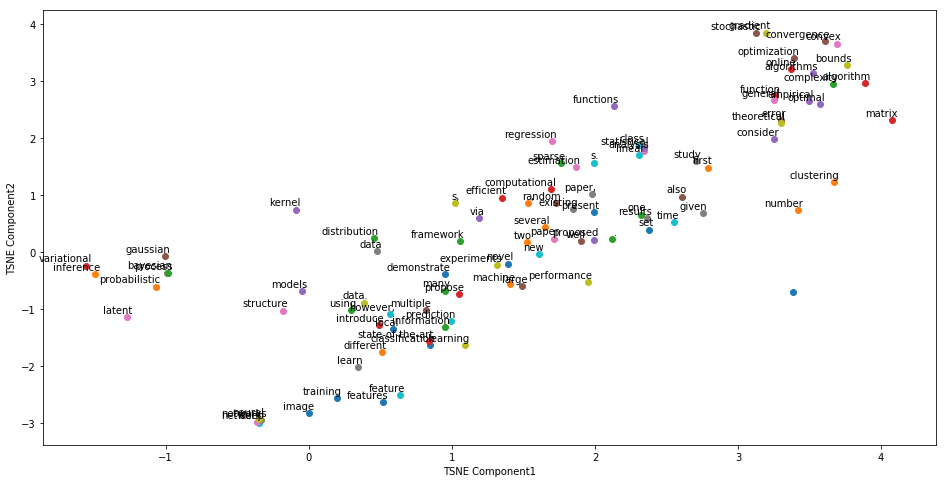

In [8]:
model = word2vec.Word2Vec(corpus, size=200, window=10, min_count=500, workers=4, seed=82)
model.corpus_count

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in sorted(model.wv.vocab):
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', method='exact', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.xlabel('TSNE Component1')
    plt.ylabel('TSNE Component2')
    plt.show()
    
tsne_plot(model)

# 3. NMF for topic modeling and t-SNE for 2D-embedding

We have used 2D-embeddings to visualize the content of all NIPS papers until 2017. In doing so, we have used the method in [1] as a benchmark.

We have choosen the topics for clusters from our WordCloud analysis in the section 1 above for the words with higher appearance in NIPS papers till 2017. These topics are: 
### neural network, bayesian, clustering, optimization, learning, kernel, artificial, reinforcement, image.

[1]. https://www.kaggle.com/rjhere23/nips-papers-visualized-with-nmf-and-t-sne

In [ ]:
#conn = sqlite3.connect('/Users/behrouz/Desktop/Harvard/Week 2/Class 2/section2/data/section2/database.sqlite')

#papers = pd.read_sql_query("select * from papers;", conn)
#papers.columns = ['id','year','title','event_type','pdf_name','abstract','paper_text']
papers = pd.read_csv(path_to_csv)

In [ ]:
#For this analysis we will use "Papers Text" to identify the growth of the topics from 1997 until 2017. 

n_features = 1000
n_topics = 9
n_top_words = 10


tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features,stop_words='english')


tfidf = tfidf_vectorizer.fit_transform(papers['paper_text'])


nmf = NMF(n_components=n_topics, random_state=0,alpha=.1, l1_ratio=.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [ ]:
nmf_embedding = nmf.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

In [ ]:
topics = ['neural network',
          'bayesian',
          'clustering',
          'optimization',
          'learning',
          'kernel',
          'artificial',
          'reinforcement',
          'image']  

In [ ]:
tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)

In [ ]:
###code used to create the plot for getting the colors 
#plt.style.use('ggplot')
colors = np.array([[ 0.89411765,  0.10196079,  0.10980392,  1. ],
                   [ 0.22685121,  0.51898501,  0.66574396,  1. ],
                   [ 0.38731259,  0.57588621,  0.39148022,  1. ],
                   [ 0.7655671 ,  0.38651289,  0.37099578,  1. ],
                   [ 1.        ,  0.78937332,  0.11607843,  1. ],
                   [ 0.75226453,  0.52958094,  0.16938101,  1. ],
                   [ 0.92752019,  0.48406   ,  0.67238756,  1. ],
                   [ 0.60000002,  0.60000002,  0.60000002,  1. ],
                   [ 0.51898501,  0.22685121,  0.92752019,  1. ]])

legend_list = []

for i in range(len(topics)):   
    color = colors[i]
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

In [ ]:
matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')


fig, axs = plt.subplots(3,2, figsize=(10, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()

count = 0
legend = []
for year, idx in zip([1992,1997,2002,2007,2012,2017], range(6)):
    data = tsne_embedding[papers['year']<=year]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=10,c=data['hue'],cmap="Set1")
    axs[idx].set_title('Published Until {}'.format(year),**{'fontsize':'14'})
    axs[idx].axis('off')

plt.suptitle("All NIPS proceedings clustered by topic",**{'fontsize':'14','weight':'bold'})
plt.figtext(.51,0.95,'unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')
#fig.legend(legend_list)
fig.legend(legend_list,topics,loc=(0.1,0.89),ncol=3)
plt.subplots_adjust(top=0.85)

plt.show()

# 4. FIND TOPICS AND PLOT TOPICS AGAINST TIME

In [ ]:
df_papers = pd.read_csv(path_to_csv)
print(df_papers.shape)
df_papers.head()
df_papers_orig = df_papers.copy()

# LOWER CASE
df_papers.loc[:,'title'] = df_papers.title.apply(lambda x : x.lower())
df_papers.loc[:,'paper_text'] = df_papers.paper_text.apply(lambda x : x.lower())

#KEEP ONLY ALPHANUMERIC
regex = re.compile(r'\W+')
df_papers.loc[:,'title'] = df_papers.title.apply(lambda x: regex.sub(' ', x))
df_papers.loc[:,'paper_text'] = df_papers.paper_text.apply(lambda x: regex.sub(' ', x))

#CONVERT TO BOW
df_papers.loc[:,'title'] = df_papers['title'].apply(lambda x: x.split(' '))
df_papers.loc[:,'paper_text'] = df_papers['paper_text'].apply(lambda x: x.split(' '))

porter = PorterStemmer()
stops = set(stopwords.words("english"))
stops = stops.union(set("year"))

#REMOVE STOP WORDS
df_papers.loc[:,'title'] = df_papers['title'].apply(lambda x: [word for word in x if word not in stops])
df_papers.loc[:,'paper_text'] = df_papers['paper_text'].apply(lambda x: [word for word in x if word not in stops])

# INCREASE WEIGHT ON THE WORDS USED IN THE TITLES BY COUNTING THEM 4 times
title_overcount_factor = 3

def build_corpus(data): 
    corpus = []
    for index, row in data.iterrows():
        title = []
        for i in range(title_overcount_factor):
            title = row['title'] + title
        content = title + row['paper_text']
        corpus.append(" ".join(content))
    return corpus

corpus = build_corpus(df_papers)


In [ ]:
n_samples = len(corpus)
print ("There are %i documents to analyze." % n_samples)
n_features = 2000
n_components = 10
n_top_words = 20

In [ ]:
from datetime import datetime
from time import time

n_features = 2000

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features)
t0 = time()
tf = tf_vectorizer.fit_transform(corpus)
print("done in %0.3fs." % (time() - t0))
print()

print("\nThe shape of our count vector matrix: ",tf.shape)
#print(tf_vectorizer.get_feature_names()[:30])


In [ ]:
n_components = 9
n_top_words = 20

print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()
    print()
    
    
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
doc_topic_distrib = lda.transform(tf)
print(doc_topic_distrib.shape)

top_n_titles = 5
for i in range(n_components):
    idx=doc_topic_distrib[:,i].argsort()[::-1][:top_n_titles]
    doc_topic_distrib[idx]
    print("Topic %d" %i )
    print(df_papers_orig.loc[idx,'title'].values)
    print()

In [ ]:
topic_names = {0:'Kernel',
               1:'Reinforcement',
               2:'topic_2',
               3:'topic_3',
               4:'topic_4',
               5:'topic_5',
               6:'Neural Network',
               7:'topic_7',
               8:'Image Recognition',
              }


In [ ]:
print(df_tfidf.shape)
df_tfidf.head()

In [ ]:
topic_list = [value for key, value in topic_names.items()]
df_topics = pd.DataFrame(doc_topic_distrib, columns=topic_list)
print(df_topics.shape)
df_topics.head()
df_topics['year'] = df_tfidf['year']


In [ ]:
df_topics_year = df_topics.groupby('year').mean()
topics = set(topic_list)
plot_trend(df_topics_year, topics)


# 5. Use TFIDF to find the important terms for each year and get a first impression of the trends


In [ ]:
# PARAMETERS FOR TFIDF
min_ngram = 2
max_ngram = 2

max_df = 0.90
min_df = 2
max_features = 500

vectorizer = TfidfVectorizer(ngram_range=(min_ngram, max_ngram), max_features = max_features, max_df = max_df)
X = vectorizer.fit_transform(corpus)
print(X.get_shape())

#print((vectorizer.get_feature_names()))
#print(X.has_sorted_indices)

In [ ]:
# CONVERT TFIDF RESULTS TO PANDAS DATA FRAME
df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
print(df_tfidf.shape)
# ADD THE YEAR COLUMN TO THE DATAFRAME
df_tfidf['year'] = df_papers['year']
df_tfidf['count'] = 1
print(df_tfidf.shape)



In [ ]:
#GROUP BY YEAR

#GET THE NUMBER OF PAPERS FOR EACH YEAR 
counts = df_tfidf.groupby(['year']).agg(['count'])['count']

#TAKE THE MEAN IDF SCORE FOR EACH FEATURE
df_tfidf_year = df_tfidf.groupby(['year']).mean()

#ADD THE COUNT COLUMN FOR EACH YEAR FOR FUTURE USE
df_tfidf_year['count'] = counts
df_tfidf_year.head()


In [ ]:
# PARAMETERS FOR PLOTTING
topN_topics = 25  # PLOT THE TOPICS THAT FEATURED IN THE TOPN OF EACH YEAR
min_year = 2013   # THE MIN BOUND FOR THE YEARS TO LOOK AT TO FIND THE TOP TOPICS
max_year = 2017   # THE MAX BOUND FOR THE YEARS TO LOOK AT TO FIND THE TOP TOPICS


# ITERATE THROUGH EACH YEAR AND PICK THE TOP (top_n) TOPICS FROM EACH YEAR TO PLOT
years = df_tfidf_year.index
print(years)
topics  = set()
for year in years:
        if (year >= min_year) & (year <=max_year):
            tfidf_sorted = df_tfidf_year.T.sort_values(by=[year], ascending=False)
            topics = topics.union(set(tfidf_sorted.index[:topN_topics]))

print(len(topics))

# REMOVE TOPICS THAT ARE KNOWN TO BE NOT RELATED TO MACHINE LEARNING
remove_set = set(["using", "et al", "count", "based", "via", "semi", "online", 
                  "large", "multi", "analysis", "data", "stochastic", "log log", "low rank"])

# FINAL LIST OF TOPICS TO PLOT
topics = topics.difference(remove_set)

plt.figure(figsize=(20,10))
for topic in topics:
    plt.plot(df_tfidf_year.index, df_tfidf_year.loc[:,topic])
plt.xticks(df_tfidf_year.index)
plt.legend(loc = 'upper left')


In [ ]:
# PLOT ONLY TERMS THAT HAVE A CONSISTENTLY RISING TREND
plt.rcParams['figure.figsize'] = [10, 5]
def upward_trend (column):
        upward_trend = df_tfidf_year.loc[2017,column] > df_tfidf_year.loc[2016, column] > df_tfidf_year.loc[2015, column] 
        return upward_trend

def downward_trend(column):
        downward_trend = df_tfidf_year.loc[2017,column] < df_tfidf_year.loc[2016, column] < df_tfidf_year.loc[2015, column]< \
        df_tfidf_year.loc[2014, column] 
        return downward_trend


topics_upward = set()
topics_downward = set()
for column in df_tfidf_year.columns:
    #print(df_tfidf_year.loc[2017,column])
    #print(df_tfidf_year.loc[2016,column]) 
    if upward_trend(column) :
            topics_upward.add(column)
    elif downward_trend(column):
            topics_downward.add(column)
       

    
# REMOVE TOPICS THAT ARE KNOWN TO BE NOT RELATED TO MACHINE LEARNING
remove_set = set(["systems pages", "neural network", "related work", "conference neural", "mini batch" 
                   "log log", "low rank", "end end", "international conference", "arxiv preprint", 
                  "related work", "preprint arxiv", "two different", "long term" , "fixed point", "error rates", "standard deviation",
                  'et al', 'kernel methods',  'supported part', 'multi task', 'total number', 
                  'two dimensional', 'cifar 10', 'natural language', 'error rates', 'task learning', 'artificial neural', 'editors advances', 
                  'standard deviation', 'count', 'pattern analysis', 'optimal policy', 'reward function', 
                  'deep neural', 'number iterations', 'analysis machine', 'kernel function', 'recurrent neural', 'state action', 'gaussian kernel', 
                  'joint distribution', 'function approximation', 'input space', 'international conference', 'number parameters', 'proceedings ieee', 
                  'proposed method', 'real data', 'information processing', 'domain adaptation', 
                  'conference computer', 'learning methods', 'model based', 'x0 x0', 'processing systems', 'end end', 'advances neural', 
                  'neural network', 'density estimation', 'al 2016', 'conference neural', 'theoretical analysis', 'see figure', 
                  'ground truth', 'linear combination', 'state art', 'synthetic data', 'theoretical results', 'cost function', 'see fig', 'recent work', 
                  'arxiv preprint', 'high probability', 'results shown', 'experimental results', 'systems pages', 'labeled data', 
                  'training data', 'two different', 'mini batch', 'preprint arxiv', 'would like', 'neural information', 'conference learning', 
                  'mean squared', 'prior knowledge', 'machine intelligence','system nips', '40 50', 'fixed point', 'non gaussian', 'long term', 'non parametric', 'information theoretic', 'related work'
                  'neural computation', 'ij ij', 'gaussian noise', '20 30', 'principal component', '15 20', 'given set', 'xi xj', '13 14', 'mixture model', 'vector machine', 'small number', 'message passing', 
                  'high dimensional', 'covariance matrix', 'nips pages', 'described section', 'firing rate', 'mit press', 'previous work', 'diagonal matrix', '16 17', 
                  'em algorithm', 'learning rule', 'markov random', 'data points', 'technical report', '100 150', '20 40', 'least squares', 'many applications', 'fig shows', 'graphical model', 
                  'learning problems', 'edu abstract', 'gaussian mixture', '40 60', 'number clusters', '20 10', 'one dimensional', 'random fields',
                  'feature selection', 'state space', 'sample size', 'non zero', 'graphical models', 'science university', 'partition function', 'xt xt', 
                  'main result', 'special case'
                 
                 ])
        
# FINAL LIST OF TOPICS TO PLOT
topics_upward = topics_upward.difference(remove_set)
topics_downward = topics_downward.difference(remove_set)

#topics = set(["computer vision", "deep learning", "neural networks", "value function", "pattern recognition",
#               "reinforcement learning" ,"information processing"])



def plot_trend(df, topics, title):
    plt.figure(figsize=(20,8))
    plt.title(title, fontsize=25)
    for topic in topics:
        plt.plot(df.index, df.loc[:,topic])
    plt.xticks(df.index)
    plt.legend(loc = 'upper left')
print("UPWARD:")
print(topics_downward)
print("DOWNWARD:")
print(topics_downward)

plot_trend(df_tfidf_year, topics_upward, "Topics trending UPWARDS for the last 3 years")
plot_trend(df_tfidf_year, topics_downward,  "Topics trending DOWNWARDS for the last 3 years")